In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import datasets
from sklearn import cross_validation
from sklearn import tree
from sklearn import metrics

In [3]:
sns.set_style("whitegrid")
sns.set_color_codes()
%matplotlib inline

# Functions

In [4]:
def calc_lift(x,y,clf,bins=10):

    #Actual Value of y
    y_actual = y
    #Predicted Probability that y = 1
    y_prob = clf.predict_proba(x)
    #Predicted Value of Y
    y_pred = clf.predict(x)
    cols = ['ACTUAL','PROB_POSITIVE','PREDICTED']
    data = [y_actual,y_prob[:,1],y_pred]
    df = pd.DataFrame(dict(zip(cols,data)))
    
    #Observations where y=1
    total_positive_n = df['ACTUAL'].sum()
    #Total Observations
    total_n = df.index.size
    natural_positive_prob = total_positive_n/float(total_n)
    
    #Check to see if predicted zeros exceed single bin
    zero_count = df.loc[df['PROB_POSITIVE']==0,'PROB_POSITIVE'].index.size
    zero_pct = zero_count/float(total_n)
    
    #Check to see if predicted ones exceed single bin
    one_count = df.loc[df['PROB_POSITIVE']==1,'PROB_POSITIVE'].index.size
    one_pct = one_count/float(total_n)

    #If zeros exceed single bin, add random noise
    if zero_pct > 1/float(bins): 
        print('Too many zeros!')
        #Find min non-negative predicted probability
        prob_min = df.loc[df['PROB_POSITIVE']!=0,'PROB_POSITIVE'].min()
        df.loc[df['PROB_POSITIVE']==0,'PROB_POSITIVE'] = np.random.uniform(0,prob_min,zero_count)
    #If ones exceed single bin, add random noise
    if one_pct > 1/float(bins):
        print("Too many ones!")
        prob_max = df.loc[df['PROB_POSITIVE']!=1,'PROB_POSITIVE'].max()
        df.loc[df['PROB_POSITIVE']==1,'PROB_POSITIVE'] = np.random.uniform(prob_max,1,one_count)

    #Create Bins where First Bin has Observations with the
    #Lowest Predicted Probability that y = 1
    df['BIN_POSITIVE'] = pd.qcut(df['PROB_POSITIVE'],bins,labels=False)
    
    pos_group_df = df.groupby('BIN_POSITIVE')
    #Percentage of Observations in each Bin where y = 1 
    count_positive = pos_group_df['ACTUAL'].sum()
    count_bin = pos_group_df['ACTUAL'].count()
    lift_positive = count_positive/count_bin
    lift_index_positive = (lift_positive/natural_positive_prob)*100
    
    
    #Consolidate Results into Output Dataframe
    lift_df = pd.DataFrame({
                'COUNT_POSITIVE': count_positive,
                'COUNT_BIN': count_bin,
                'LIFT_POSITIVE':lift_positive,
                'LIFT_POSITIVE_INDEX':lift_index_positive,
                'BASELINE_POSITIVE':natural_positive_prob})
    
    #Calculate Data for Gains Chart
    lift_df = lift_df.append(pd.DataFrame(np.zeros((1,5)),index=[10],columns=lift_df.columns))
    lift_df.sort_index(ascending=False,inplace=True)
    lift_df['CUM_POSITIVE'] = lift_df['COUNT_POSITIVE'].cumsum()/lift_df['COUNT_POSITIVE'].sum()
    lift_df['CUM_TOTAL'] = lift_df['COUNT_BIN'].cumsum()/lift_df['COUNT_BIN'].sum()
    
    return lift_df

In [5]:
def plot_lift_gains(data):
    fig = plt.figure(figsize=(12,6))

    #Configure Grid
    gs = gridspec.GridSpec(2,1)


    #Add Subplots
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[1,0])

    lift_plot_data = data[data['CUM_TOTAL']>0]
    ax1.plot(lift_plot_data['CUM_TOTAL'], lift_plot_data['LIFT_POSITIVE_INDEX'],color='g', label='Classifier Performance')
    ax1.axhline(100,linestyle='dashed',color='r',label="Baseline Performance")
    ax1.set_ylim(top=1000)

    ax2.plot(data['CUM_TOTAL'],data['CUM_POSITIVE'],color='g',label='Classifier Performance')
    ax2.plot(data['CUM_TOTAL'],data['CUM_TOTAL'],color='r',linestyle='dashed',label='Baseline Performance')

    ax1.fill_between(lift_plot_data['CUM_TOTAL'],lift_plot_data['LIFT_POSITIVE_INDEX'],100,where=lift_plot_data['LIFT_POSITIVE_INDEX']>=100,interpolate=True,color='g',alpha=0.25)
    ax2.fill_between(data['CUM_TOTAL'],data['CUM_POSITIVE'],data['CUM_TOTAL'],where= data['CUM_POSITIVE']> data['CUM_TOTAL'],interpolate=True,color='g',alpha=0.25)

    ax1.legend(loc='center right',frameon=True)
    ax2.legend(loc='center right',frameon=True)


    ax1.set_xticks(np.linspace(0,1,6))

    y1_vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.0f}x'.format(val/100) for val in y1_vals])

    x2_vals = ax2.get_xticks()
    ax2.set_xticklabels(['{:3.0f}%'.format(val*100) for val in x2_vals])

    y2_vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.0f}%'.format(val*100) for val in y2_vals])


    ax1.xaxis.set_ticklabels([])
    ax2.set_xlabel("Percent of Users Sent Invites")

    ax1.set_ylabel("Upgrade Lift Index")
    ax1.yaxis.set_label_coords(-0.05,0.5)

    ax2.set_ylabel("Percent of Total Upgraders")

    ax1.set_title("Lift Chart")
    ax2.set_title("Gains Chart")



    gs.tight_layout(fig)
    return (gs,fig,ax1,ax2)


In [13]:
def lift_wrapper(x,y,min_samples_leaf=10,class_weight=None):
    x_train, x_test, y_train, y_test =  cross_validation.train_test_split(x,y,test_size=0.3,random_state=1000)
    clf = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf,class_weight=class_weight)
    clf.fit(x_train,y_train)
    y_predicted = clf.predict(x_test)
    print(metrics.classification_report(y_test,y_predicted))
    lift_df = calc_lift(x_test,y_test,clf,bins=10)
    gs,fig,ax1,ax2 = plot_lift_gains(lift_df)
    return (lift_df,gs,fig,ax1,ax2)

# Lift Plots

## Base Case

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      2841
          1       0.54      0.32      0.40       159

avg / total       0.94      0.95      0.94      3000

Too many zeros!


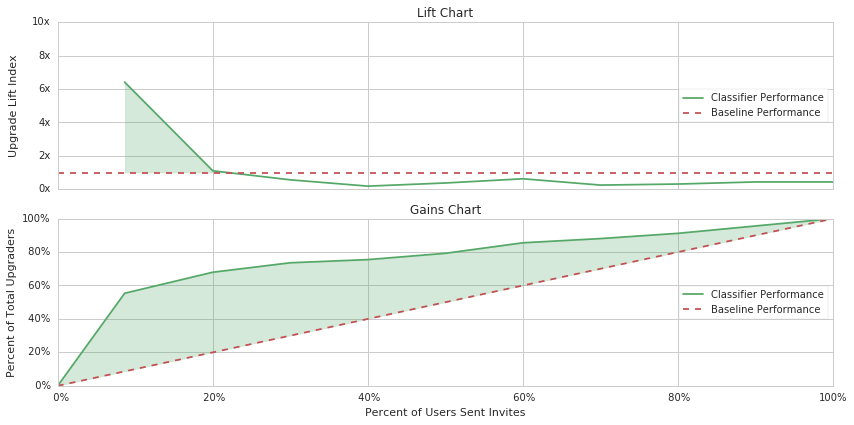

In [7]:
x,y = datasets.make_classification(n_samples=10000, n_features=20,
                                   n_informative=15,n_redundant=5,
                                   n_classes=2, weights=[0.95,0.05],
                                   random_state=1000)
x_train, x_test, y_train, y_test =  cross_validation.train_test_split(x,y,
                                                                      test_size=0.3,random_state=1000)
clf = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf,
                                  class_weight=class_weight)
clf.fit(x_train,y_train)
    
gs,fig,ax1,ax2 = lift_wrapper(x,y)
#plt.savefig('base_plot.png',dpi=300,bbox_inches='tight')

## Balanced Classes

             precision    recall  f1-score   support

          0       0.98      0.88      0.93      2841
          1       0.23      0.65      0.34       159

avg / total       0.94      0.87      0.89      3000

Too many zeros!


(<matplotlib.gridspec.GridSpec at 0x7f6923bfa050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6909762650>)

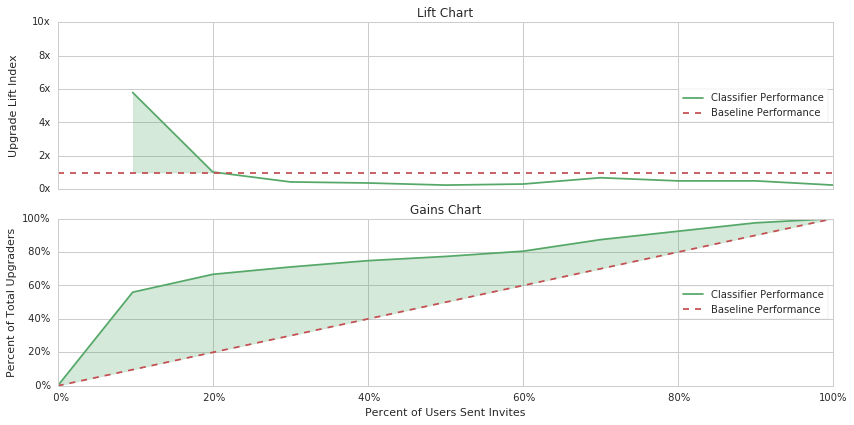

In [8]:
x,y = datasets.make_classification(n_samples=10000, n_features=20, n_informative=15,n_redundant=5, n_classes=2, weights=[0.95,0.05],random_state=1000)
lift_wrapper(x,y,10,'balanced')

## Min Samples = 50

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2841
          1       0.36      0.06      0.11       159

avg / total       0.92      0.94      0.93      3000

Too many zeros!


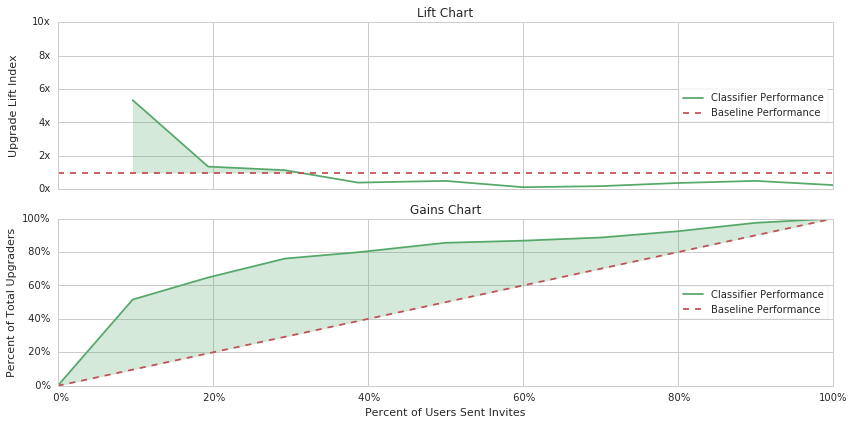

In [27]:
x,y = datasets.make_classification(n_samples=10000, n_features=20, n_informative=15,n_redundant=5, n_classes=2, weights=[0.95,0.05],random_state=1000)
lift_df,gs,fig,ax1,ax2 = lift_wrapper(x,y,50)

In [28]:
lift_df.reset_index(inplace=True)

In [32]:
df = lift_df.loc[lift_df.BIN_POSITIVE <10, ['BIN_POSITIVE','BASELINE_POSITIVE','COUNT_POSITIVE','COUNT_BIN','LIFT_POSITIVE','LIFT_POSITIVE_INDEX']]

In [33]:
df.rename(columns={'BIN_POSITIVE':'Group', 'BASELINE_POSITIVE':'Baseline Upgrade Rate', 'COUNT_POSITIVE':'Number of Upgrades','COUNT_BIN':'Number of Users','LIFT_POSITIVE':'Upgrade Rate','LIFT_POSITIVE_INDEX':'Upgrade Index'})

,Group,Baseline Upgrade Rate,Number of Upgrades,Number of Users,Upgrade Rate,Upgrade Index
1,9,0.053,82.0,290.0,0.282759,533.506831
2,8,0.053,21.0,292.0,0.071918,135.693978
3,7,0.053,18.0,297.0,0.060606,114.351058
4,6,0.053,6.0,283.0,0.021201,40.002667
5,5,0.053,9.0,338.0,0.026627,50.240036
6,4,0.053,2.0,300.0,0.006667,12.578616
7,3,0.053,3.0,300.0,0.010000,18.867925
8,2,0.053,6.0,300.0,0.020000,37.735849
9,1,0.053,8.0,300.0,0.026667,50.314465
10,0,0.053,4.0,300.0,0.013333,25.157233


In [17]:
lift_df.reset_index().loc(lift_df.BIN_POSITIVE <10, ['BIN_POSITIVE'])

,BIN_POSITIVE,BASELINE_POSITIVE,COUNT_BIN,COUNT_POSITIVE,LIFT_POSITIVE,LIFT_POSITIVE_INDEX,CUM_POSITIVE,CUM_TOTAL
0,10,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,9,0.053,290.0,82.0,0.282759,533.506831,0.515723,0.096667
2,8,0.053,302.0,21.0,0.069536,131.200800,0.647799,0.197333
3,7,0.053,287.0,18.0,0.062718,118.335415,0.761006,0.293000
4,6,0.053,299.0,8.0,0.026756,50.482741,0.811321,0.392667
5,5,0.053,322.0,7.0,0.021739,41.017227,0.855346,0.500000
6,4,0.053,300.0,3.0,0.010000,18.867925,0.874214,0.600000
7,3,0.053,300.0,5.0,0.016667,31.446541,0.905660,0.700000
8,2,0.053,300.0,6.0,0.020000,37.735849,0.943396,0.800000
9,1,0.053,300.0,2.0,0.006667,12.578616,0.955975,0.900000


             precision    recall  f1-score   support

          0       0.97      0.96      0.96      2841
          1       0.39      0.46      0.42       159

avg / total       0.94      0.93      0.94      3000

Too many zeros!


(<matplotlib.gridspec.GridSpec at 0x7f6933297c90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6909411290>)

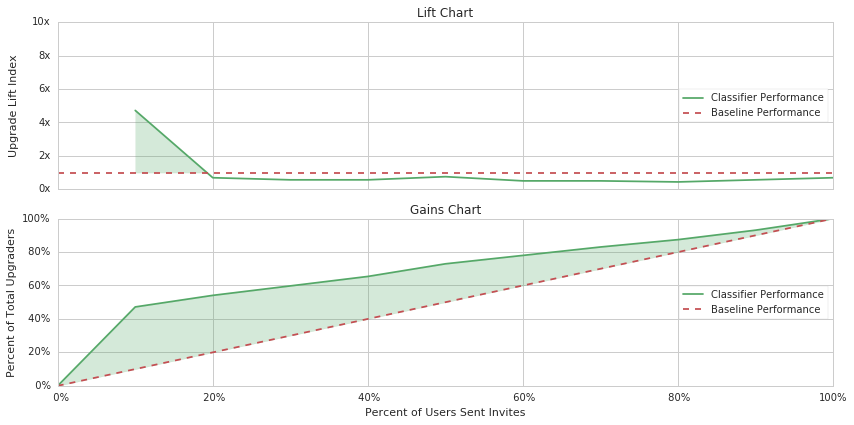

In [10]:
x,y = datasets.make_classification(n_samples=10000, n_features=20, n_informative=15,n_redundant=5, n_classes=2, weights=[0.95,0.05],random_state=1000)
lift_wrapper(x,y,1)

## Add Noise

             precision    recall  f1-score   support

          0       0.88      0.92      0.90      2604
          1       0.26      0.18      0.21       396

avg / total       0.80      0.82      0.81      3000

Too many zeros!


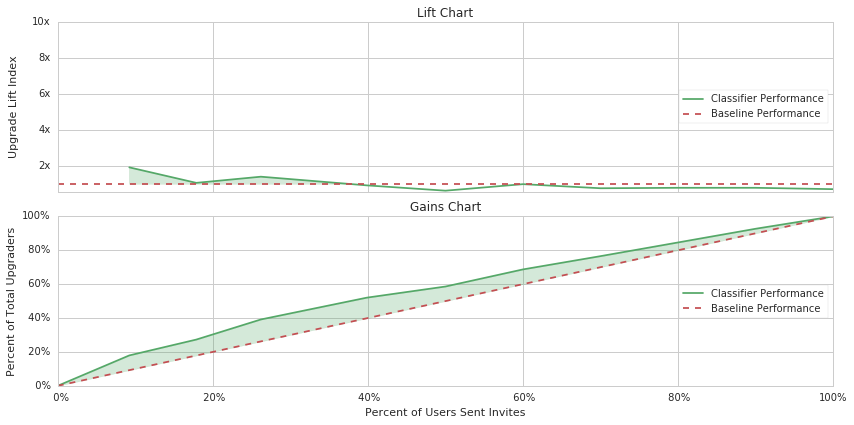

In [11]:
x,y = datasets.make_classification(n_samples=10000, n_features=20, n_informative=15,n_redundant=5, n_classes=2, weights=[0.95,0.05],random_state=1000, flip_y=0.2)
gs,fig,ax1,ax2 = lift_wrapper(x,y)
plt.savefig('bad_plot.png',dpi=300,bbox_inches='tight')

## Close Class Proportions

             precision    recall  f1-score   support

          0       0.85      0.90      0.87      1774
          1       0.84      0.77      0.81      1226

avg / total       0.85      0.85      0.85      3000

Too many zeros!
Too many ones!


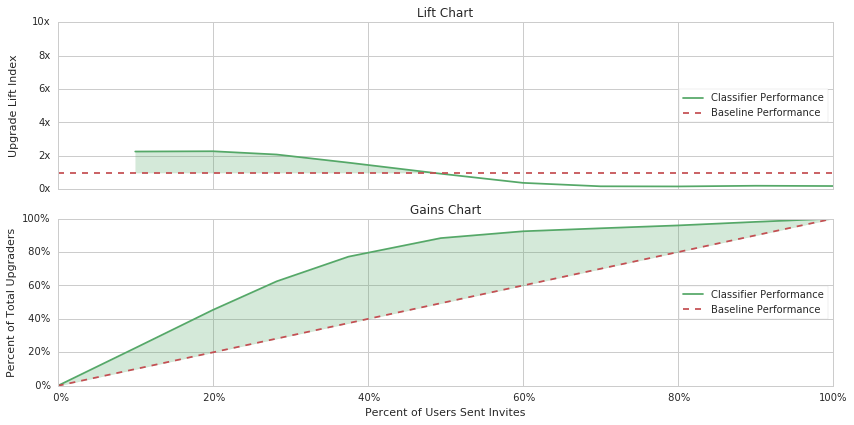

In [12]:
x,y = datasets.make_classification(n_samples=10000, n_features=20, n_informative=15,n_redundant=5, n_classes=2, weights=[0.6,0.4],random_state=1000)
gs,fig,ax1,ax2 = lift_wrapper(x,y)
plt.savefig('bad_plot.png',dpi=300,bbox_inches='tight')